_Ilhem OUASSINI , I2-APP RS1_

__Dans ce notebook, vous trouverez le code, les commentaires, ainsi que les résultats obtenus. Le rapport "Lab_3_classification_OUASSINI" fournit une analyse détaillée et une interprétation approfondie de ces résultats.__

# LAB 4 : Clustering on IOT-detection and NSL-KDDD

## Part 1: Introduction to Clustering

Dans cette partie, nous présentons le clustering, une technique qui regroupe des points de données similaires. Nous utiliserons le dataset NSL-KDD pour classer le trafic en deux catégories : "normal" et "suspect". De même, nous pourrons regrouper les appareils IoT selon leurs modèles d'activité. Nous nous concentrerons sur deux algorithmes d'apprentissage non supervisé :

- K-means : divise les données en un nombre prédéfini de groupes en rassemblant des points similaires.
- Clustering Hiérarchique (CAH) : crée des clusters progressivement en fusionnant des points de données similaires.

## Part 2: Loading the Data

## __Dataset IOT__

In [8]:
# importe de la bibliothèque pandas pour la manipulation des données
import pandas as pd

# charge le fichier CSV contenant les données IoT dans un DataFrame
df = pd.read_csv('label_feature_IOT.csv')
# affiche les premières lignes du DataFrame
df.head()  

,Label,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,SequenceNumber,AckNumber,WindowSize,TCPHeaderLength,TCPLength,TCPStream,TCPUrgentPointer,IPFlags,IPID,IPchecksum,TCPflags,TCPChecksum
0,TCP_Assistant,281,20,64,6,36171,443,1,1,1597,20,241,0,0,0x02,0xe0e0,0x9e5d,0x0018,0xc650
1,TCP_Assistant,40,20,64,6,36171,443,242,93,1597,20,0,0,0,0x02,0xe0e1,0x9f4d,0x0010,0xd2b2
2,TCP_Assistant,52,20,64,6,45990,443,1,1,406,32,0,1,0,0x02,0x5aee,0xa23f,0x0010,0x2147
3,TCP_Assistant,121,20,64,6,36836,443,1,1,406,32,69,2,0,0x02,0x8539,0x4150,0x0018,0xb3dc
4,TCP_Assistant,90,20,64,6,36836,443,70,1,406,32,38,2,0,0x02,0x853a,0x416e,0x0018,0x450f


In [9]:
# importe la classe LabelEncoder pour encoder les caractéristiques
from sklearn.preprocessing import LabelEncoder
# crée une instance de LabelEncoder
le = LabelEncoder()
# transforme chaque caractéristique en un entier
df['Label'] = le.fit_transform(df['Label'])
# affiche les 5 premières lignes du DataFrame
df.head()

,Label,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,SequenceNumber,AckNumber,WindowSize,TCPHeaderLength,TCPLength,TCPStream,TCPUrgentPointer,IPFlags,IPID,IPchecksum,TCPflags,TCPChecksum
0,0,281,20,64,6,36171,443,1,1,1597,20,241,0,0,0x02,0xe0e0,0x9e5d,0x0018,0xc650
1,0,40,20,64,6,36171,443,242,93,1597,20,0,0,0,0x02,0xe0e1,0x9f4d,0x0010,0xd2b2
2,0,52,20,64,6,45990,443,1,1,406,32,0,1,0,0x02,0x5aee,0xa23f,0x0010,0x2147
3,0,121,20,64,6,36836,443,1,1,406,32,69,2,0,0x02,0x8539,0x4150,0x0018,0xb3dc
4,0,90,20,64,6,36836,443,70,1,406,32,38,2,0,0x02,0x853a,0x416e,0x0018,0x450f


In [10]:
# liste des colonnes contenant des valeurs en hexadécimal
hex_columns = ['IPFlags', 'IPID', 'IPchecksum', 'TCPflags', 'TCPChecksum']
# conversion des valeurs hexadécimales en décimaux pour les colonnes concernées 
for col in hex_columns:
    df[col] = df[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)

# suppression de la colonne Label pour obtenir seulement les 18 caractérisques (donnée d'entrée)
X = df.drop('Label', axis=1)
# création d'une variable qui concerne uniquement la colonne Label (résultat à prédire)
y = df['Label']
df.head()

,Label,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,SequenceNumber,AckNumber,WindowSize,TCPHeaderLength,TCPLength,TCPStream,TCPUrgentPointer,IPFlags,IPID,IPchecksum,TCPflags,TCPChecksum
0,0,281,20,64,6,36171,443,1,1,1597,20,241,0,0,2,57568,40541,24,50768
1,0,40,20,64,6,36171,443,242,93,1597,20,0,0,0,2,57569,40781,16,53938
2,0,52,20,64,6,45990,443,1,1,406,32,0,1,0,2,23278,41535,16,8519
3,0,121,20,64,6,36836,443,1,1,406,32,69,2,0,2,34105,16720,24,46044
4,0,90,20,64,6,36836,443,70,1,406,32,38,2,0,2,34106,16750,24,17679


In [11]:
# Suppression des colonnes non pertinentes pour le K-means clustering
columns_to_drop = ['Label', 'SequenceNumber', 'AckNumber', 'TCPStream', 'TCPUrgentPointer', 'IPFlags', 'IPID', 'IPchecksum', 'TCPflags', 'TCPChecksum']

df = df.drop(columns=columns_to_drop)

### Remarque

Nous avons supprimé les colonnes non pertinentes pour le K-means clustering, telles que 'Label', 'SequenceNumber' et d'autres caractéristiques, car elles n'apportent pas d'informations utiles pour le regroupement des données, ce qui pourrait nuire à l'identification des clusters.

In [13]:
# importe train_test_split pour diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

# division du dataset : d'entraînement et de test
# 70% des données seront utilisées pour l'entraînement
# 30% des données seront utilisées pour les tests 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# importe StandardScaler pour ajuter les caractéristiques 
from sklearn.preprocessing import StandardScaler
# création d'un objet StandardScaler 
scaler = StandardScaler()
# ajustement du scaler sur les données d'entraînement et transformation
X_train = scaler.fit_transform(X_train)
# transformation des données de test, utilisant le même scaler
X_test = scaler.transform(X_test)

In [15]:
# Sauvegarde du dataset prétraité en un nouveau fichier CSV
df.to_csv('iot_dataset_pre-processed.csv', index=False)


In [16]:
# Recharger le dataset prétraité
df_pretraite = pd.read_csv('iot_dataset_pre-processed.csv')

# Afficher les premières lignes du dataset pour vérifier
df_pretraite.head()


,IPLength,IPHeaderLength,TTL,Protocol,SourcePort,DestPort,WindowSize,TCPHeaderLength,TCPLength
0,281,20,64,6,36171,443,1597,20,241
1,40,20,64,6,36171,443,1597,20,0
2,52,20,64,6,45990,443,406,32,0
3,121,20,64,6,36836,443,406,32,69
4,90,20,64,6,36836,443,406,32,38


## __Dataset NSL-KDD__

In [18]:
import pandas as pd
# Charger les ensembles de données d'entraînement et de test NSL-KDD
column_names = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level']) # Add the 43 column names from the NSL-KDD dataset
# Lire le fichier d'entraînement 'KDDTrain+.txt' sans en-tête, en utilisant les noms de colonnes spécifiés
train_df = pd.read_csv('KDDTrain+.txt', header=None, names=column_names)
# Lire le fichier de test 'KDDTest+.txt' sans en-tête, en utilisant les noms de colonnes spécifiés
test_df = pd.read_csv('KDDTest+.txt', header=None, names=column_names)
train_df


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [19]:
# Transformer les valeurs de la colonne 'outcome' en valeurs binaires :
# Attribuer 0 si l'étiquette est 'normal', sinon attribuer 1
Trained_attack = train_df.outcome.map(lambda a: 0 if a == 'normal' else 1)
Tested_attack = test_df.outcome.map(lambda a: 0 if a == 'normal' else 1)
# Ajouter la colonne 'classification' au DataFrame d'entraînement avec les valeurs transformées
train_df['classification'] = Trained_attack
# Ajouter la colonne 'classification' au DataFrame de test avec les valeurs transformées
test_df['classification'] = Tested_attack

In [20]:
from sklearn.preprocessing import LabelEncoder
# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()
# Encoder les valeurs de la colonne 'outcome' dans l'ensemble d'entraînement et ajouter une nouvelle colonne 'label'
train_df['label'] = label_encoder.fit_transform(train_df['outcome'])
# Encoder les valeurs de la colonne 'outcome' dans l'ensemble de test en utilisant le même encodage et ajouter une nouvelle colonne 'label'
test_df['label'] = label_encoder.fit_transform(test_df['outcome'])

In [21]:
from sklearn.preprocessing import LabelEncoder

# Créer une instance de LabelEncoder pour chaque colonne catégorielle
label_encoder = LabelEncoder()

# Encoder les colonnes dans l'ensemble d'entraînement
train_df['protocol_type'] = label_encoder.fit_transform(train_df['protocol_type'])
train_df['service'] = label_encoder.fit_transform(train_df['service'])
train_df['flag'] = label_encoder.fit_transform(train_df['flag'])

# Encoder les colonnes dans l'ensemble de test en utilisant les mêmes encodages
test_df['protocol_type'] = label_encoder.fit_transform(test_df['protocol_type'])
test_df['service'] = label_encoder.fit_transform(test_df['service'])
test_df['flag'] = label_encoder.fit_transform(test_df['flag'])

# Afficher les DataFrames modifiés
train_df
test_df


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level,classification,label
0,0,1,45,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1,14
1,0,1,45,1,0,0,0,0,0,0,...,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21,1,14
2,2,1,19,9,12983,0,0,0,0,0,...,0.61,0.02,0.00,0.0,0.00,0.00,normal,21,0,16
3,0,0,13,9,20,0,0,0,0,0,...,1.00,0.28,0.00,0.0,0.00,0.00,saint,15,1,24
4,1,1,55,2,0,15,0,0,0,0,...,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,0,16
22540,0,1,22,9,317,938,0,0,0,0,...,0.01,0.01,0.01,0.0,0.00,0.00,normal,21,0,16
22541,0,1,22,9,54540,8314,0,0,0,2,...,0.00,0.00,0.00,0.0,0.07,0.07,back,15,1,1
22542,0,2,11,9,42,42,0,0,0,0,...,0.00,0.00,0.00,0.0,0.00,0.00,normal,21,0,16


In [22]:
# Supprime la colonne 'outcome' des ensembles de données d'entraînement et de test
train_df = train_df.drop(columns=['outcome'])
test_df = test_df.drop(columns=['outcome'])

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Définir les caractéristiques (features) et la cible (target)
X_train = train_df.drop(columns=[ 'land', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
                    'count', 'srv_count', 'num_failed_logins', 'num_compromised', 'num_root', 
                    'num_file_creations', 'num_shells', 'num_access_files'])

y_train = train_df['classification']

X_test = test_df.drop(columns=[ 'land', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
                    'count', 'srv_count', 'num_failed_logins', 'num_compromised', 'num_root', 
                    'num_file_creations', 'num_shells', 'num_access_files'])

y_test = test_df['classification']

# Normaliser les caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Suppression des colonnes
columns_to_drop = [ 'label', 'land', 'wrong_fragment', 'urgent']
train_df = train_df.drop(columns=columns_to_drop)
train_df


,duration,protocol_type,service,flag,src_bytes,dst_bytes,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,classification
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,0,1,24,9,232,8153,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,0,1,24,9,199,420,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,49,5,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,20,1
125969,8,2,49,9,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,21,0
125970,0,1,54,9,2231,384,0,0,1,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,18,0
125971,0,1,30,5,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,20,1


In [25]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,classification,label
0,0,1,45,1,0,0,0,0,0,0,...,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1,14
1,0,1,45,1,0,0,0,0,0,0,...,0.06,0.00,0.00,0.00,0.0,1.00,1.00,21,1,14
2,2,1,19,9,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.00,0.0,0.00,0.00,21,0,16
3,0,0,13,9,20,0,0,0,0,0,...,0.00,1.00,0.28,0.00,0.0,0.00,0.00,15,1,24
4,1,1,55,2,0,15,0,0,0,0,...,0.17,0.03,0.02,0.00,0.0,0.83,0.71,11,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,0.06,0.01,0.01,0.01,0.0,0.00,0.00,21,0,16
22540,0,1,22,9,317,938,0,0,0,0,...,0.00,0.01,0.01,0.01,0.0,0.00,0.00,21,0,16
22541,0,1,22,9,54540,8314,0,0,0,2,...,0.00,0.00,0.00,0.00,0.0,0.07,0.07,15,1,1
22542,0,2,11,9,42,42,0,0,0,0,...,0.01,0.00,0.00,0.00,0.0,0.00,0.00,21,0,16


### Remarque

Nous avons supprimé les colonnes 'label', 'land', 'wrong_fragment' et 'urgent' du dataset NSL-KDD, car elles ne fournissent pas d'informations essentielles pour l'analyse, ce qui pourrait compliquer l'identification des modèles de trafic et des anomalies.

In [27]:
# Sauvegarder le DataFrame d'entraînement et le DataFrame de test en fichiers CSV
train_df.to_csv('nsl_kdd_simple.csv', index=False)


Nous avons choisi d'utiliser le jeu de données d'entraînement (train) du dataset NSL-KDD car il contient suffisamment d'exemples pour entraîner efficacement le modèle et optimiser le processus de clustering.

In [29]:
# Recharger le dataset prétraité
df_pretraite = pd.read_csv('nsl_kdd_simple.csv')

# Afficher les premières lignes du dataset pour vérifier
df_pretraite.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,classification
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,0,1,24,9,232,8153,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,0,1,24,9,199,420,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0


## Part 3: K-means Clustering

## __IOT__

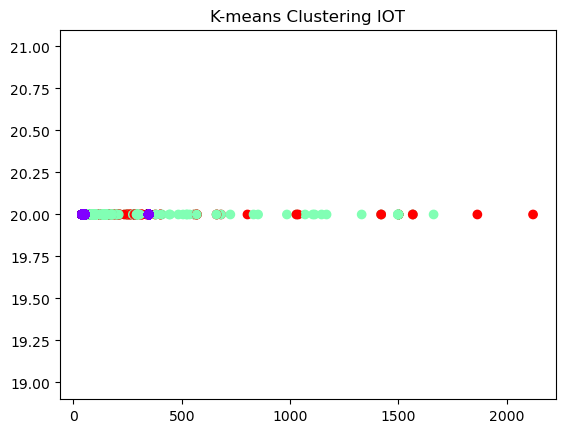

In [32]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# Load the dataset IoT-detection
data = pd.read_csv('iot_dataset_pre-processed.csv') 
# K-means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(data)
# Plotting the clusters using the first two features
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title('K-means Clustering IOT')
plt.show()

### PCA

Le PCA est une technique de réduction de dimensionnalité qui transforme un jeu de données multivarié en un nouveau jeu de données avec moins de dimensions, tout en préservant la variance.

L'application de PCA avant K-Means aide à visualiser les clusters. Cela permet de voir clairement la séparation entre les groupes. PCA réduit également le bruit dans les données. Cela améliore la performance de l'algorithme et rend le calcul plus efficace.

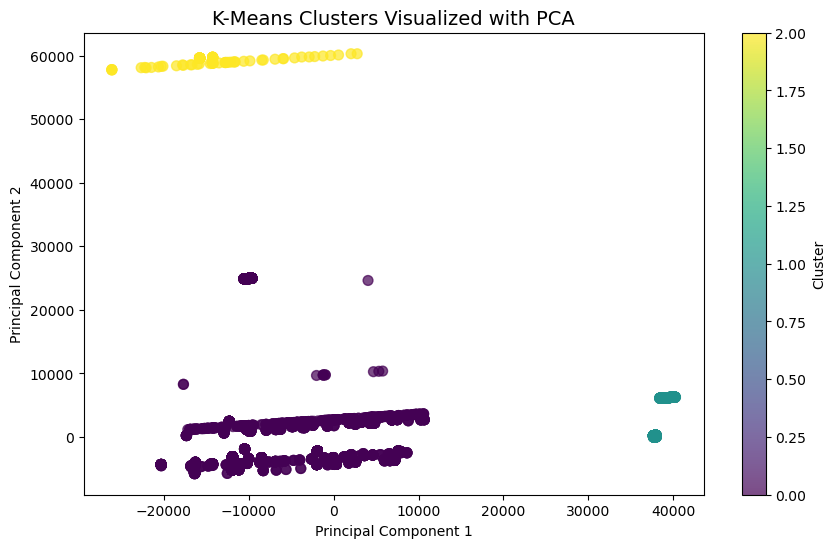

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Étape 1 : Charger le dataset prétraité
data = pd.read_csv('iot_dataset_pre-processed.csv')

# Étape 2 : Appliquer K-means Clustering avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajout d'un random_state pour la reproductibilité
kmeans_labels = kmeans.fit_predict(data)

# Étape 3 : Appliquer PCA pour réduire le dataset à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)  # Utilise 'data' qui contient le dataset prétraité

# Étape 4 : Créer un scatter plot des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)

# Ajouter des titres et des labels
plt.title('K-Means Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Ajouter une color bar pour montrer les assignments des clusters
plt.colorbar(label='Cluster')

# Afficher le plot
plt.show()



### t-SNE

L'utilisation de t-SNE avant K-Means permet de visualiser les données dans un espace réduit. Cela aide à identifier la structure des clusters. t-SNE conserve les relations locales entre les points. Il met en évidence les similitudes dans les données. Cette technique améliore la compréhension des groupes avant le clustering.

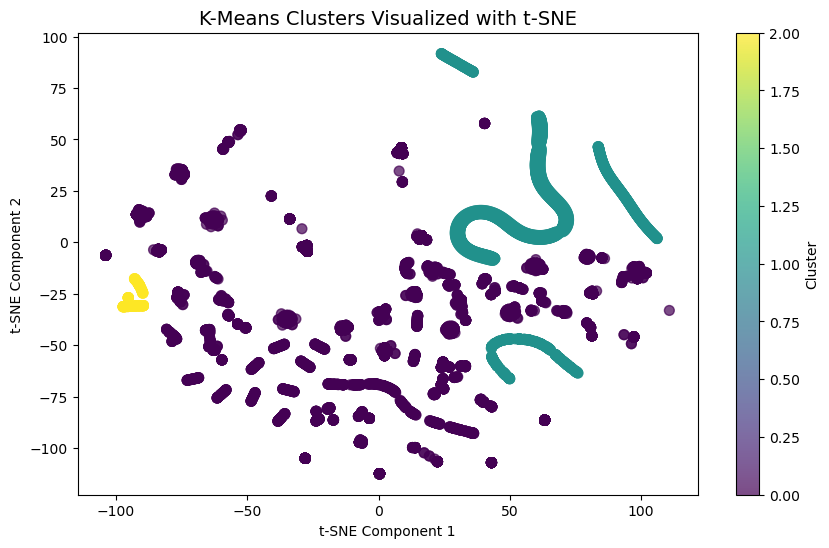

In [36]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Étape 1 : Charger le dataset prétraité
data = pd.read_csv('iot_dataset_pre-processed.csv')

# Étape 2 : Appliquer K-means Clustering avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajout d'un random_state pour la reproductibilité
kmeans_labels = kmeans.fit_predict(data)

# Étape 3 : Appliquer t-SNE pour réduire le dataset à 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Tu peux ajuster la perplexité si nécessaire
X_tsne = tsne.fit_transform(data)

# Étape 4 : Créer un scatter plot des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)

# Ajouter des titres et des labels
plt.title('K-Means Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Ajouter une color bar pour montrer les assignments des clusters
plt.colorbar(label='Cluster')

# Afficher le plot
plt.show()


## __NSL__

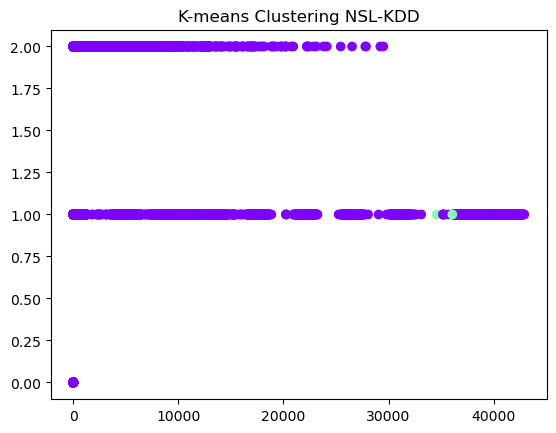

In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# Load the dataset NSL-KDD 
data = pd.read_csv('nsl_kdd_simple.csv') 
# K-means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(data)
# Plotting the clusters using the first two features
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title('K-means Clustering NSL-KDD')
plt.show()

### PCA

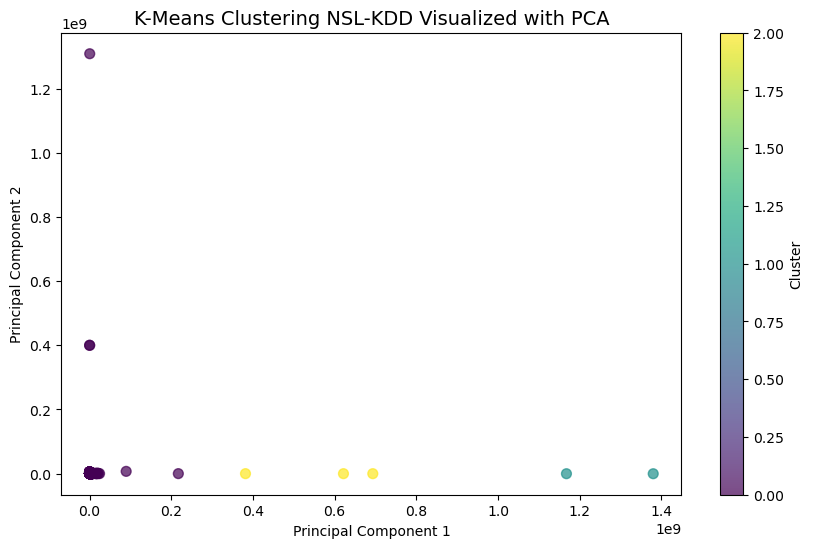

In [40]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Étape 1 : Charger le dataset NSL-KDD
data = pd.read_csv('nsl_kdd_simple.csv')

# Étape 2 : Appliquer K-means Clustering avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajout d'un random_state pour la reproductibilité
kmeans_labels = kmeans.fit_predict(data)

# Étape 3 : Appliquer PCA pour réduire le dataset à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)  # Utilise 'data' qui contient le dataset NSL-KDD

# Étape 4 : Créer un scatter plot des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)

# Ajouter des titres et des labels
plt.title('K-Means Clustering NSL-KDD Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Ajouter une color bar pour montrer les assignments des clusters
plt.colorbar(label='Cluster')

# Afficher le plot
plt.show()


### t-SNE

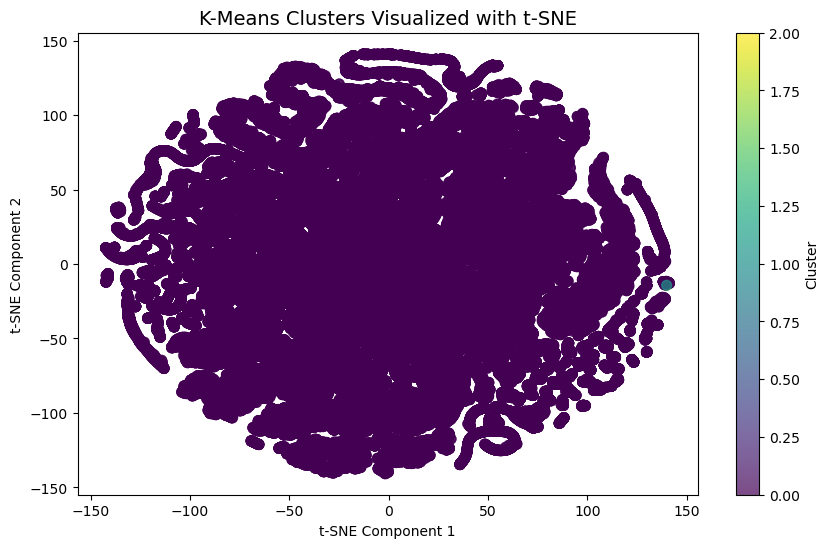

In [42]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Étape 1 : Charger le dataset prétraité NSL-KDD
data = pd.read_csv('nsl_kdd_simple.csv')  # Remplace par le bon chemin si nécessaire

# Étape 2 : Appliquer K-means Clustering avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajout d'un random_state pour la reproductibilité
kmeans_labels = kmeans.fit_predict(data)

# Étape 3 : Appliquer t-SNE pour réduire le dataset à 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Ajuste la perplexité si nécessaire
X_tsne = tsne.fit_transform(data)

# Étape 4 : Créer un scatter plot des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)

# Ajouter des titres et des labels
plt.title('K-Means Clusters Visualized with t-SNE', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Ajouter une color bar pour montrer les assignments des clusters
plt.colorbar(label='Cluster')

# Afficher le plot
plt.show()


## Part 4: Hierarchical Clustering (CAH)

__IOT__

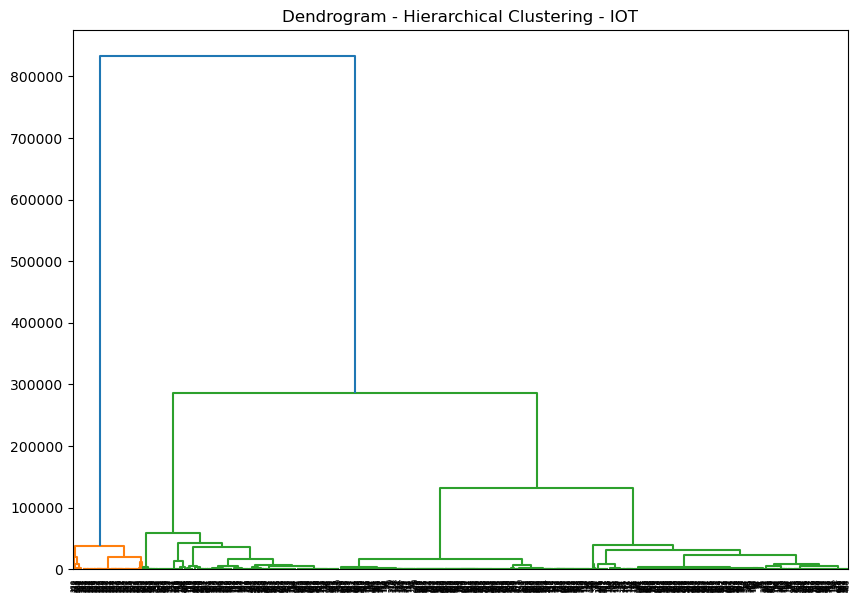

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
data = pd.read_csv('iot_dataset_pre-processed.csv', nrows=1000)
# Create the linkage matrix using the Ward method
linked = linkage(data, method='ward')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram - Hierarchical Clustering - IOT')
plt.show()

__NSL-KDD__

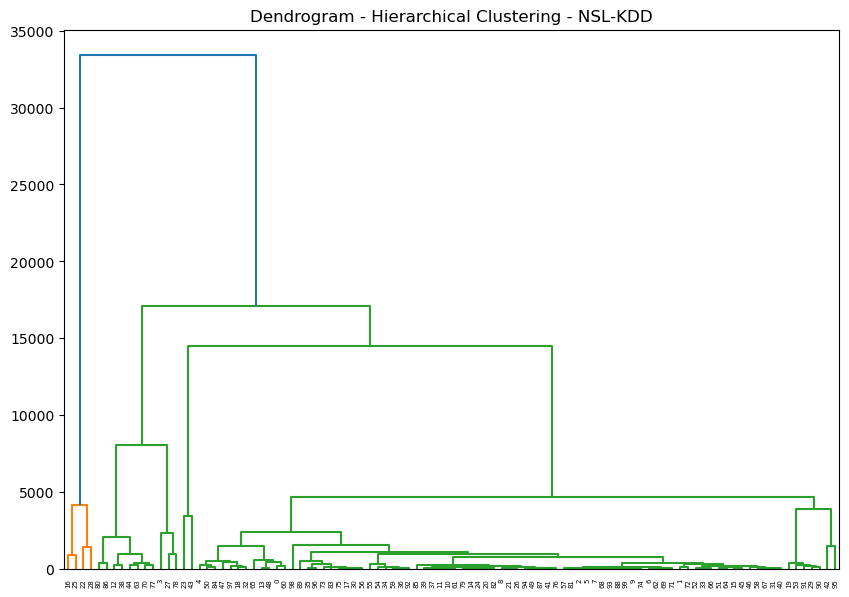

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
data = pd.read_csv('nsl_kdd_simple.csv', nrows=100)
# Create the linkage matrix using the Ward method
linked = linkage(data, method='ward')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram - Hierarchical Clustering - NSL-KDD')
plt.show()

## Part 5: Questions to Answer

__Veuillez consulter le rapport intitulé LAB4 pour trouver les réponses aux questions.__

## Autre observation

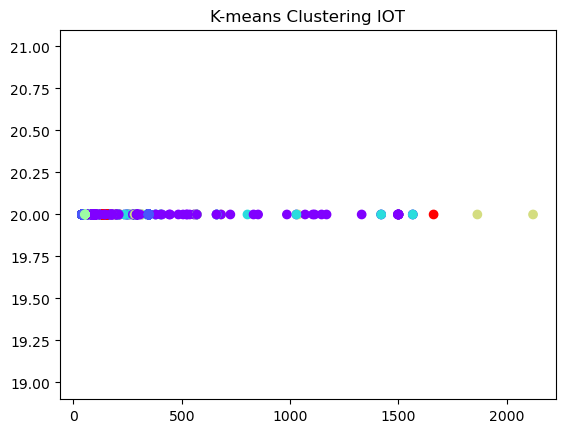

In [51]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# Load the dataset IoT-detection
data = pd.read_csv('iot_dataset_pre-processed.csv') 
# K-means Clustering with 3 clusters
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(data)
# Plotting the clusters using the first two features
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title('K-means Clustering IOT')
plt.show()

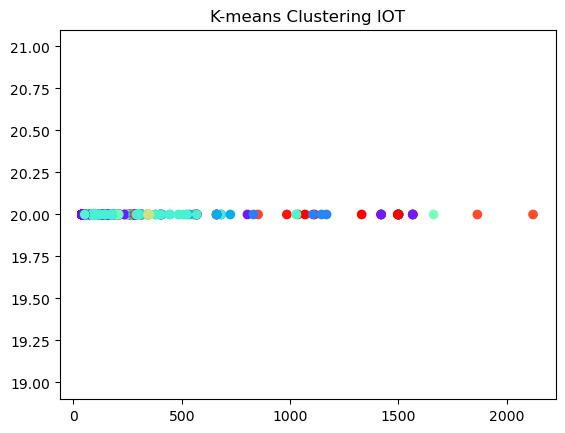

In [52]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# Load the dataset IoT-detection
data = pd.read_csv('iot_dataset_pre-processed.csv') 
# K-means Clustering with 3 clusters
kmeans = KMeans(n_clusters=80)
kmeans_labels = kmeans.fit_predict(data)
# Plotting the clusters using the first two features
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title('K-means Clustering IOT')
plt.show()

On observe que dans le K-means du dataset IoT, en augmentant le nombre de clusters (par exemple : de KMeans(n_clusters=10) & KMeans(n_clusters=80)), le graphique présente davantage de couleurs. Cependant, les points restent à la même position sur le graphique.

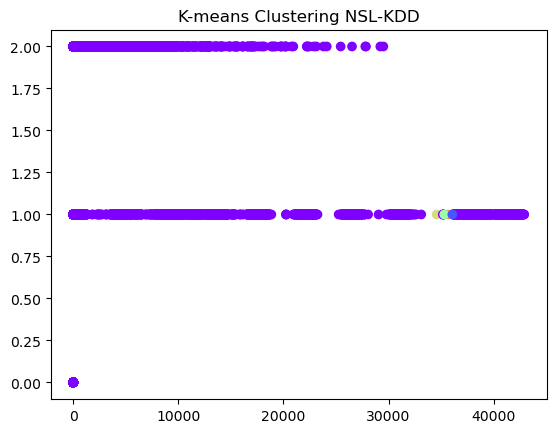

In [54]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# Load the dataset NSL-KDD 
data = pd.read_csv('nsl_kdd_simple.csv') 
# K-means Clustering with 3 clusters
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(data)
# Plotting the clusters using the first two features
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title('K-means Clustering NSL-KDD')
plt.show()

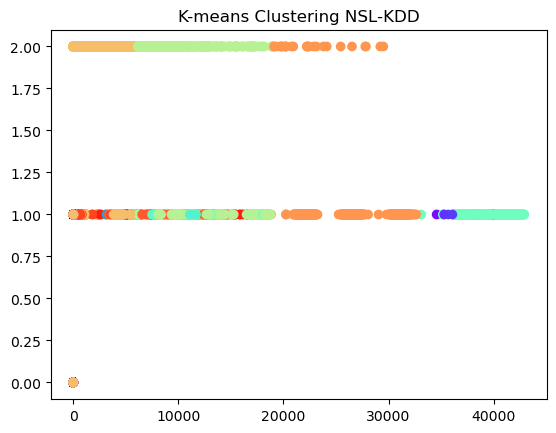

In [55]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# Load the dataset NSL-KDD 
data = pd.read_csv('nsl_kdd_simple.csv') 
# K-means Clustering with 3 clusters
kmeans = KMeans(n_clusters=80)
kmeans_labels = kmeans.fit_predict(data)
# Plotting the clusters using the first two features
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=kmeans_labels, cmap='rainbow')
plt.title('K-means Clustering NSL-KDD')
plt.show()

On remarque que dans le K-means du dataset NSL-KDD, lorsque l'on augmente le nombre de clusters (par exemple : de KMeans(n_clusters=10) & KMeans(n_clusters=80)), le graphique affiche également plus de couleurs. Cependant, les points conservent la même position sur le graphique.